# Histogram of Oriented Gradients

Step 1: Import packages.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Step 2: Define constants.

In [2]:
img_filename = 'hog.jpg'
im_shape = (32, 32) # shape of image
cell_shape = (8, 8) # shape of cell
block_stride = (8, 8) # how many pixels a block move each time
num_bins = 8 # number of bins. 180 / 8 = 20
block_size = (2, 2) # 2cells x 2cells
block_shape = (block_size[0] * cell_shape[0], block_size[1] * cell_shape[1]) # shape of block
print('block_shape:', block_shape)

block_stride_per_block = (block_stride[0] // cell_shape[0], block_stride[1] // cell_shape[1]) # how many cells a block move each time
print('block_stride_per_block:', block_stride_per_block)

block_shape: (16, 16)
block_stride_per_block: (1, 1)


Step 3: graying

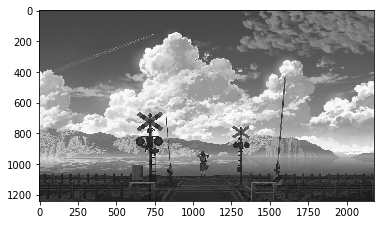

In [3]:
img = Image.open(img_filename).convert('L')
img = np.asarray(img, float)

def imshow(img, cmap=None):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()
imshow(img, cmap='gray')

Step 4: Reshape

In [4]:
# resize shape to (32, 32) or im_shape
img = Image.fromarray(img)
if img.size != im_shape:
    img = img.resize(im_shape, resample=Image.BICUBIC)
img = np.asarray(img, dtype=float)

Step 5: Gamma

In [5]:
img = img ** 2.5
img = (img - np.mean(img)) / np.std(img)

Step 6: Calculate grads

In [6]:
# Calculates grads including size and orientation
def cal_grad(img):
    grads = np.zeros(img.shape, float)
    dirs = np.zeros(img.shape, float)
    
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            if h - 1 >=0 and w - 1 >= 0 and h + 1 < img.shape[0] and w + 1 < img.shape[1]:
                dx = img[h, w + 1] - img[h, w - 1] + 0.0001 # smooth
                dy = img[h + 1, w] - img[h - 1, w]
                dirs[h, w] = np.arctan(dy / dx) * 180 / np.pi
                if dirs[h, w] < 0:
                    dirs[h, w] += 180
                grads[h, w] = np.sqrt(dx ** 2 + dy ** 2)
    return grads, dirs

grads, dirs = cal_grad(img)
print(grads.shape, dirs.shape)

(32, 32) (32, 32)


Step 6: Calculate cell histograms.

In [7]:
num_cells = (im_shape[0] // cell_shape[0], im_shape[1] // cell_shape[1])
cells = np.zeros((num_cells[0], num_cells[1], num_bins), float)
for i in range(num_cells[0]):
    for j in range(num_cells[1]):
        start_h = i * cell_shape[0]
        start_w = j * cell_shape[1]
        cell_dirs = dirs[start_h: start_h + cell_shape[0], start_w: start_w + cell_shape[1]]
        cell_grads = grads[start_h: start_h + cell_shape[0], start_w: start_w + cell_shape[1]]
        cell, _ = np.histogram(cell_dirs, bins=num_bins, range=(0, 180), weights=cell_grads)
        
        cells[i, j] = cell
        #cells.append(cell)
        
print('num_cells:', num_cells)
print('cells.shape:', cells.shape)

num_cells: (4, 4)
cells.shape: (4, 4, 8)


Step 7: Calculatet block features

In [8]:
num_blocks = ((im_shape[0] - block_shape[0]) // 8 + 1, (im_shape[1] - block_shape[1]) // 8 + 1)
print('num_blocks:', num_blocks) # (3, 3)

blocks = list()
for i in range(num_blocks[0]):
    for j in range(num_blocks[1]):
        start_h = i * block_stride_per_block[0]
        start_w = j * block_stride_per_block[1]
        block = cells[start_h: start_h + block_size[0], start_w: start_w + block_size[1]]
        block = block / np.linalg.norm(block)
        block = block.reshape(-1)
        blocks.append(block)
blocks = np.asarray(blocks).reshape(-1)
print('blocks.shape:', blocks.shape)
print(blocks)

num_blocks: (3, 3)
blocks.shape: (288,)
[7.87380383e-04 0.00000000e+00 1.11186264e-02 1.78261876e-02
 9.60692236e-03 6.19449243e-03 0.00000000e+00 1.38210493e-03
 2.55369613e-01 1.96537765e-01 2.96422523e-01 1.11685511e-01
 4.99354546e-02 6.67459146e-02 1.80399130e-01 2.48610395e-02
 1.99706558e-01 6.08050637e-02 1.36861068e-01 1.38046609e-01
 6.73137791e-02 5.14981707e-02 2.80481993e-01 8.87261308e-02
 4.83490420e-01 3.91875843e-01 2.05528311e-01 2.57010638e-01
 9.90253759e-02 1.56976390e-01 1.24180202e-01 1.85866645e-01
 2.23728773e-01 1.72186316e-01 2.59695139e-01 9.78474377e-02
 4.37483451e-02 5.84759533e-02 1.58047293e-01 2.17807037e-02
 5.13687273e-02 1.36122508e-02 2.74561474e-02 4.99267782e-02
 7.54021035e-02 3.07609656e-02 2.41943590e-02 1.08892236e-02
 4.23584925e-01 3.43321590e-01 1.80062915e-01 2.25166472e-01
 8.67559204e-02 1.37526680e-01 1.08794010e-01 1.62837371e-01
 3.19508112e-01 2.68567317e-01 2.58398608e-01 2.46859817e-01
 1.25961993e-01 1.31051273e-01 8.92210640e-02